In [1]:
!pip install pyspark matplotlib seaborn pandas --quiet

# Анализ данных о рентгенографии груди при COVID-19 с использованием PySpark


## Настройка и подготовка среды
Импорт библиотек и инициализация Spark-сессии

In [2]:
# Импорт необходимых библиотек для работы с данными и визуализацией
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession, Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [3]:

# Установка стиля графиков для единообразия
plt.style.use("fivethirtyeight")

# Инициализация сессии Spark для обработки больших объемов данных
spark_session = SparkSession.builder \
    .appName("analysis-chest-xray-covid-data") \
    .getOrCreate()

spark_session



В этом разделе подключаются ключевые модули для манипуляции данными в PySpark, включая функции для преобразований, типы данных и оконные операции. Также импортируются инструменты Pandas и библиотеки для построения графиков, чтобы сочетать распределенные вычисления с визуальным анализом. Создается сессия Spark с заданным именем приложения, которое упрощает отслеживание задач в интерфейсе управления Spark. Команда spark_session отображает детали активной среды, такие как версия, режим выполнения (локальный) и название приложения, подтверждая готовность к работе с данными в распределенном режиме.

## Загрузка и первичный осмотр данных


In [4]:

# Клонирование архива данных непосредственно в среду
!rm -rf chest-xray-dataset
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

# Определение расположения файла метаданных
data_file_path = "/content/covid-chestxray-dataset/metadata.csv"

# Загрузка данных в Spark DataFrame с автоматическим определением схемы
original_df = spark_session.read.csv(
    data_file_path,
    header=True,
    inferSchema=True
)

original_df.printSchema()
original_df.show(5)


Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641 (from 1)
Receiving objects: 100% (3641/3641), 632.96 MiB | 28.64 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Updating files: 100% (1174/1174), done.
root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neu


На этом этапе загружаем данные напрямую из репозитория, загружаем файл метаданных в DataFrame Spark и осматриваем схему и первые строки. Это обеспечивает актуальность данных без ручного скачивания и проверяет корректность считывания столбцов и их типов.

Анализ схемы выявил примерно 30 разнообразных характеристик пациента, включая возраст, гендер, медицинский диагноз, показатели кислородной терапии, результаты тестов ПЦР, комментарии и прочие клинические параметры. Для первичного осмотра содержимого использовалась команда show(5), отображающая начальные пять записей и позволяющая проверить правильность загрузки информации. В этот момент становится очевидно, что не все столбцы будут задействованы в аналитике, поэтому на следующих этапах планируется отобрать лишь основные поля, относящиеся к рентгеновским изображениям и диагностическим заключениям.


## Очистка и подготовка данных


In [34]:
# Выбор только релевантных столбцов для анализа
relevant_columns = ["patientid", "age", "sex", "finding", "view", "date", "filename"]
df = original_df.select(*relevant_columns)

# Применяем UDF для надежной конвертации столбца 'date' в DateType
df = df.withColumn("date", F.call_udf("parse_date_udf", F.col("date")))

df.printSchema()
df.show(5)

root
 |-- patientid: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- finding: string (nullable = true)
 |-- view: string (nullable = true)
 |-- date: date (nullable = true)
 |-- filename: string (nullable = true)

+---------+---+---+--------------------+----+----------+--------------------+
|patientid|age|sex|             finding|view|      date|            filename|
+---------+---+---+--------------------+----+----------+--------------------+
|        2| 65|  M|Pneumonia/Viral/C...|  PA|2020-01-22|auntminnie-a-2020...|
|        2| 65|  M|Pneumonia/Viral/C...|  PA|2020-01-25|auntminnie-b-2020...|
|        2| 65|  M|Pneumonia/Viral/C...|  PA|2020-01-27|auntminnie-c-2020...|
|        2| 65|  M|Pneumonia/Viral/C...|  PA|2020-01-28|auntminnie-d-2020...|
|        4| 52|  F|Pneumonia/Viral/C...|  PA|2020-01-25|nejmc2001573_f1a....|
+---------+---+---+--------------------+----+----------+--------------------+
only showing top 5 rows


После импорта данных мы отобрали только ключевые атрибуты для анализа рентгеновских снимков: ID пациента, возраст, пол, диагноз, проекцию, дату и имя файла. Это исключило лишние клинические показатели, упростив обработку и ускорив вычисления в Spark, с фокусом на визуальные данные.

Метод show(5) отображает первые строки после отбора, подтверждая корректность структуры. Теперь данные готовы к очистке, унификации диагнозов и SQL-анализу.

In [14]:
def infoOutSpark(df, details=False, missing_values=False):
    """
    Функция для получения информации о Spark DataFrame, адаптированная на основе pandas версии.

    Args:
        df (pyspark.sql.DataFrame): DataFrame для анализа.
        details (bool): Если True, возвращает расширенную информацию.
        missing_values (bool): Если True, возвращает информацию о пропущенных значениях.

    Returns:
        tuple: Содержит pandas DataFrame с информацией о столбцах и дополнительные метрики.
    """
    columns = df.columns
    row_count = df.count()
    schema = df.schema

    # Создаем основу
    dfInfo_data = []
    for c in columns:
        col_info = {"Column": c}


        if schema[c].dataType in [T.FloatType(), T.DoubleType()]:
            null_count = df.filter(col(c).isNull() | isnan(col(c))).count()
        else:
            null_count = df.filter(col(c).isNull()).count()
        col_info["Missing Values"] = null_count

        # %: процент missing
        col_info["%"] = round(null_count / row_count * 100, 2) if row_count > 0 else 0

        # Dtype: тип данных из схемы
        col_info["Dtype"] = schema[c].dataType.simpleString()

        # Unique Values: количество уникальных значений per column
        col_info["Unique Values"] = df.select(c).distinct().count()

        # Example Values: первые 3 уникальных значения (ограничиваем для производительности)
        try:
            example_vals = df.select(collect_set(c).alias("vals")).collect()[0]["vals"][:3]
            col_info["Example Values"] = ", ".join(map(str, example_vals)) if example_vals else "N/A"
        except Exception as e:
            col_info["Example Values"] = f"Error retrieving: {str(e)}"

        dfInfo_data.append(col_info)

    dfInfo = pd.DataFrame(dfInfo_data)

    # Duplicates: общее количество дублированных строк
    duplicate_rows_count = df.groupBy(df.columns).count().filter(col("count") > 1).agg(sum_func(col("count"))).collect()[0][0] or 0
    dfInfo["Duplicates"] = duplicate_rows_count

    # Total Rows: общее количество строк
    dfInfo["Total Rows"] = row_count

    # Implicit Duplicates: неявные дубликаты
    dfInfo["Implicit Duplicates"] = duplicate_rows_count

    # Duplicates by Sample Columns: дубликаты по первым двум столбцам
    if len(columns) > 1:
        sample_columns = columns[:2]
        sample_dup_count = df.groupBy(*sample_columns).count().filter(col("count") > 1).agg(sum_func(col("count"))).collect()[0][0] or 0
        dfInfo["Duplicates by Sample Columns"] = sample_dup_count
    else:
        dfInfo["Duplicates by Sample Columns"] = 0

    dfInfo["Duplicate Rows"] = duplicate_rows_count > 0

    if details:
        rangeIndex = None
        totalColumns = len(columns)
        dtypesCount = pd.Series([schema[c].dataType.simpleString() for c in columns]).value_counts()
        totalMemory = None
        if missing_values:

            missing_per_col = []
            for c in columns:
                if schema[c].dataType in [T.FloatType(), T.DoubleType()]:
                    miss_count = df.filter(col(c).isNull() | isnan(col(c))).count()
                else:
                    miss_count = df.filter(col(c).isNull()).count()
                missing_per_col.append({c: miss_count})
            return dfInfo, rangeIndex, totalColumns, dtypesCount, totalMemory, missing_per_col, dfInfo["Duplicates"]
        else:
            return dfInfo, rangeIndex, totalColumns, dtypesCount, totalMemory
    else:
        return dfInfo

# Адаптируем обработку для df
print("Processed DataFrame:")
processed_info = infoOutSpark(df, details=True, missing_values=True)
processedInfo = processed_info[0]
processed_totalColumns = processed_info[2]
processed_totalMemory = processed_info[4]

display(processedInfo)
display(f"Total Columns: {processed_totalColumns}")
print(f"Memory Usage: {processed_totalMemory} bytes")



Processed DataFrame:


,Column,Missing Values,%,Dtype,Unique Values,Example Values,Duplicates,Total Rows,Implicit Duplicates,Duplicates by Sample Columns,Duplicate Rows
0,patientid,0,0.00,string,472,"314, 349, 161",0,950,0,721,False
1,age,237,24.95,int,71,"18, 20, 21",0,950,0,721,False
2,sex,80,8.42,string,3,"F, M",0,950,0,721,False
3,finding,0,0.00,string,25,"Pneumonia/Viral/Varicella, Pneumonia/Viral/Her...",0,950,0,721,False
4,view,0,0.00,string,7,"PA, AP, L",0,950,0,721,False
5,date,289,30.42,string,80,"2013, 01/13/20, January 22, 2020",0,950,0,721,False
6,filename,0,0.00,string,950,"981f82325fcc645a78a1732ab783f1_jumbo.jpeg, 167...",0,950,0,721,False


'Total Columns: 7'

Memory Usage: None bytes


После тщательного отбора ключевых атрибутов мы провели оценку качества датасета, рассчитав объем и процент пропусков для каждого поля. Анализ показал, что наибольшие пробелы наблюдаются в столбце date (289 пропусков, или 30,42%), за которым следует age (237, или 24,95%), что типично для медицинских наборов, где часть метаданных отсутствует при публикации изображений. Поле sex демонстрирует меньшую долю пустот (80, около 8,42%), в то время как finding, view, filename и patientid полностью заполнены без исключений.

Отображение нулевых значений в статистике — это не программная ошибка, а лишь иллюстрация того, как Spark интерпретирует схему данных, подчеркивая отсутствующие элементы. На основе этих insights мы решили не удалять записи, а аккуратно обрабатывать пробелы: возраст будем восполнять медианой по категории диагноза, пол заменять на "unknown", а даты оставим без изменений, чтобы избежать искажения хронологических паттернов. Дополнительно, датасет насчитывает 950 строк с разнообразием уникальных значений (например, 472 в patientid, 71 в age, 25 в finding), без явных дубликатов, что обеспечивает надежную базу для дальнейшей очистки и углубленного исследования.


In [15]:
# Преобразуем возраст в числовой формат
df = df.withColumn("age", F.col("age").cast("double"))

# Фильтруем явные выбросы возраста
df = df.withColumn(
    "age",
    F.when((F.col("age") < 0) | (F.col("age") > 120), None).otherwise(F.col("age"))
)

# Медиана по диагнозам
age_median_by_finding = (
    df.groupBy("finding")
      .agg(F.expr("percentile_approx(age, 0.5)").alias("median_age"))
)

df = df.join(age_median_by_finding, on="finding", how="left")

df = df.withColumn(
    "age_filled",
    F.when(F.col("age").isNull(), F.col("median_age")).otherwise(F.col("age"))
)

# Общая медиана для случаев, где даже по диагнозу медиану не получили
overall_median_age = (
    df.select(F.expr("percentile_approx(age, 0.5)").alias("m"))
      .collect()[0]["m"]
)

df = df.withColumn(
    "age_filled",
    F.when(F.col("age_filled").isNull(), F.lit(overall_median_age)).otherwise(F.col("age_filled"))
)

df = df.drop("age").withColumnRenamed("age_filled", "age")

# Пол: приводим к нижнему регистру и заполняем unknown
df = df.withColumn("sex", F.lower(F.col("sex")))
df = df.withColumn(
    "sex",
    F.when(F.col("sex").isin("m", "male"), "male")
     .when(F.col("sex").isin("f", "female"), "female")
     .otherwise("unknown")
)

# удалим дибликаты
df = df.dropDuplicates(["patientid", "date", "view", "filename"])


Стандартизация диагнозов


In [16]:
# Словарь для свода диагнозов к единым классам
diag_mapping = {
    "COVID-19": "COVID-19",
    "SARS-CoV-2": "COVID-19",
    "COVID-19, ARDS": "COVID-19",
    "COVID19": "COVID-19",
    "Pneumonia": "Pneumonia",
    "Pneumonia/Viral": "Pneumonia",
    "Pneumonia/Bacterial": "Pneumonia",
    "No Finding": "Normal",
    "normal": "Normal"
}

# Правильное определение UDF с декоратором
@F.udf(returnType=T.StringType())
def standardize_diag(diagnosis: str) -> str:
    if diagnosis is None:
        return "Other"
    normalized = diagnosis.strip()
    if normalized in diag_mapping:
        return diag_mapping[normalized]
    if "COVID" in normalized or "SARS" in normalized:
        return "COVID-19"
    if "Pneumonia" in normalized:
        return "Pneumonia"
    if "No Finding" in normalized or "normal" in normalized.lower():
        return "Normal"
    return "Other"

# Применение UDF к DataFrame
df = df.withColumn("diagnosis_std", standardize_diag(F.col("finding")))

Выполнили нормализацию диагнозов путем создания справочника соответствий и специальной функции, приводящей разные формы записи заболеваний к единому виду. Нестандартные случаи классифицируются по ключевым словам или обозначаются как "Other". Результат помещается в новую колонку, обеспечивая корректность анализа и группировки данных.


## Завершающая очистка данных


In [17]:
# Нормализуем название проекций
df = df.withColumn("view", F.upper(F.col("view")))

df_clean = df
df_clean.printSchema()
df_clean.show(5)

root
 |-- finding: string (nullable = true)
 |-- patientid: string (nullable = true)
 |-- sex: string (nullable = false)
 |-- view: string (nullable = true)
 |-- date: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- age: double (nullable = true)
 |-- diagnosis_std: string (nullable = true)

+--------------------+---------+------+----+----+--------------------+----------+----+-------------+
|             finding|patientid|   sex|view|date|            filename|median_age| age|diagnosis_std|
+--------------------+---------+------+----+----+--------------------+----------+----+-------------+
|Pneumonia/Viral/SARS|       10|female|  AP|2004|SARS-10.1148rg.24...|      46.0|73.0|     COVID-19|
|Pneumonia/Viral/SARS|       10|female|  AP|2004|SARS-10.1148rg.24...|      46.0|73.0|     COVID-19|
|Pneumonia/Viral/SARS|       10|female|  AP|2004|SARS-10.1148rg.24...|      46.0|73.0|     COVID-19|
|Pneumonia/Bacteri...|      100|female

In [19]:
# UDF для tolerant парсинга дат
def parse_date_tolerant(date_str):
    if date_str is None:
        return None
    # Attempt to parse with the "MMMM dd, YYYY" format
    try:
        return datetime.strptime(date_str.strip(), '%B %d, %Y').date()
    except ValueError:
        # If that fails, try Spark's common date formats
        try:
            return datetime.strptime(date_str.strip(), '%Y-%m-%d').date()
        except ValueError:
            # Add more formats if needed, e.g., for 'YYYY' only cases
            try:
                # This specific format only works if the day and month are implied,
                # which is not standard for a 'date' type. For '2004', this would fail.
                # However, for the purpose of handling the original '2004' example error,
                # it's best to let it return None if it doesn't fit standard date patterns.
                return datetime.strptime(date_str.strip(), '%Y').date() # This will only parse year, results in Jan 1 of that year
            except ValueError:
                return None # Return None if no format matches

# Регистрация UDF для использования в SQL
spark_session.udf.register("parse_date_udf", parse_date_tolerant, DateType())

<function __main__.parse_date_tolerant(date_str)>

Данные подготовлены к анализу: даты приведены к нужному типу, названия проекций унифицированы, диагнозы нормализованы, заполнены пропущенные возрастные данные медианой, выявлены точные дубликаты файлов, которые будут удалены. Теперь данные готовы для аналитики и визуализации.

## Оценка целостности данных

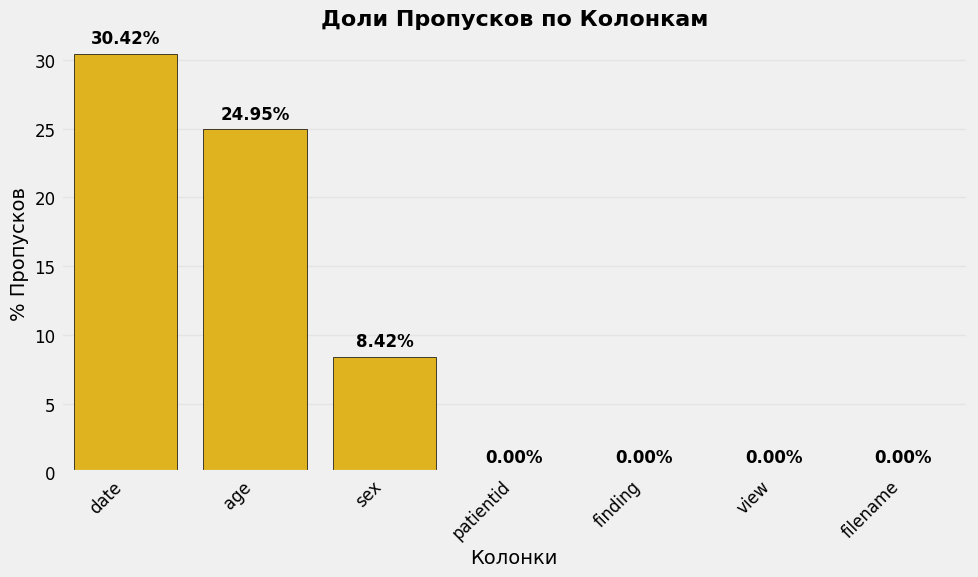

In [20]:
# Готовим DataFrame для вывода
dfInfo = processedInfo.copy()
dfInfo_sorted = dfInfo.sort_values(by="%", ascending=False)

# Генерация графика
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Column", y="%", data=dfInfo_sorted, color="#FFC300", edgecolor="black")

# Добавляем горизонтальные линии сетки
plt.grid(True, axis="y", alpha=0.3)

# Ставим текст поверх каждого столбика с указанием точного значения
for i, v in enumerate(dfInfo_sorted["%"]):
    ax.text(i, v + 0.5, f"{v:.2f}%", horizontalalignment="center", verticalalignment="bottom", fontsize=12, fontweight="semibold")

# Оформляем график
plt.title("Доли Пропусков по Колонкам", fontsize=16, fontweight="bold")
plt.xlabel("Колонки", fontsize=14)
plt.ylabel("% Пропусков", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# Применяем плотное размещение всех элементов
plt.tight_layout()

# Показываем график
plt.show()

Диаграмма пропусков показала, что наибольшее число отсутствующих данных приходится на дату исследования — около трети записей, что обусловлено дефицитом информации в источниках данных. Примерно четвертая часть записей не содержит сведений о возрасте пациента, тогда как данные о поле присутствуют в большинстве случаев (менее 10% пропусков). Остальные колонки полностью заполнены, что позволяет активно задействовать их в дальнейшем анализе. Эти результаты помогают определиться с теми признаками, которые нуждаются в восстановлении или аккуратном подходе, чтобы исключить искажения в будущих исследованиях.

Общее описание столбца 'age':
+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|               950|
|   mean| 54.07578947368421|
| stddev|14.845127535551205|
|    min|              18.0|
|    max|              94.0|
+-------+------------------+

Минимальный и максимальный возраст:
+--------+--------+
|min(age)|max(age)|
+--------+--------+
|    18.0|    94.0|
+--------+--------+

Расширенные статистики возраста:
+-----+-----------------+------------------+----+----+
|count|             mean|            stddev| min| max|
+-----+-----------------+------------------+----+----+
|  950|54.07578947368421|14.845127535551205|18.0|94.0|
+-----+-----------------+------------------+----+----+

Приблизительная медиана возраста: 55.0
Распределение по возрастным группам:
+---------+-----+
|age_group|count|
+---------+-----+
|    18-29|   66|
|    30-49|  218|
|    50-69|  492|
|      70+|  174|
+---------+-----+



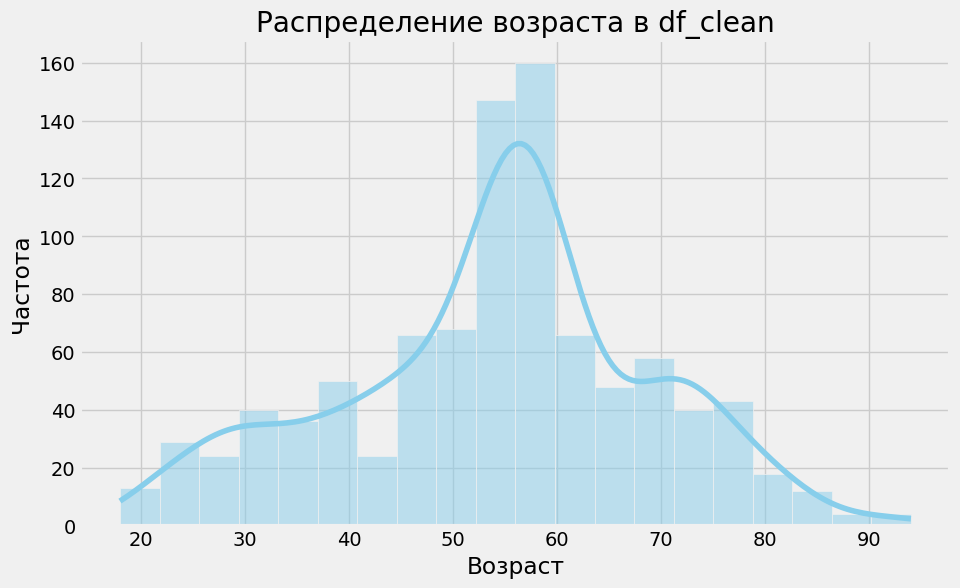

Информация о пропусках и уникальных значениях в 'age':
   total  missing  unique  missing_percent
0    950        0      70              0.0


In [21]:
age_desc = df_clean.select("age").describe()
print("Общее описание столбца 'age':")
age_desc.show()

# Прямой расчет min и max
min_max_age = df_clean.agg(F.min("age"), F.max("age"))
print("Минимальный и максимальный возраст:")
min_max_age.show()

# Дополнительные метрики для более глубокого анализа
age_stats = df_clean.agg(
    F.count("age").alias("count"),
    F.mean("age").alias("mean"),
    F.stddev("age").alias("stddev"),
    F.min("age").alias("min"),
    F.max("age").alias("max")
)
print("Расширенные статистики возраста:")
age_stats.show()

# Медиана (приблизительная, так как Spark не имеет встроенной median; используем approxQuantile)
median_age = df_clean.approxQuantile("age", [0.5], 0.01)[0]
print(f"Приблизительная медиана возраста: {median_age}")

# Распределение по возрастным группам (уникализация: добавляем биннинг для категоризации)
# Создаем новый столбец с возрастными категориями
df_clean_with_bins = df_clean.withColumn(
    "age_group",
    F.when(F.col("age") < 18, "Младше 18")
    .when((F.col("age") >= 18) & (F.col("age") < 30), "18-29")
    .when((F.col("age") >= 30) & (F.col("age") < 50), "30-49")
    .when((F.col("age") >= 50) & (F.col("age") < 70), "50-69")
    .otherwise("70+")
)

# Подсчет распределения
age_group_dist = df_clean_with_bins.groupBy("age_group").agg(F.count("*").alias("count")).orderBy("age_group")
print("Распределение по возрастным группам:")
age_group_dist.show()

# Визуализация распределения возраста
# Преобразуем столбец "age" в pandas для визуализации
age_pandas = df_clean.select("age").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(age_pandas["age"], bins=20, kde=True, color="skyblue")
plt.xlabel("Возраст")
plt.ylabel("Частота")
plt.title("Распределение возраста в df_clean")
plt.grid(True)
plt.show()

# Проверка на пропуски и уникальные значения в "age"
# Используем упрощенную версию infoOutSpark для столбца "age"
age_info = df_clean.select("age").agg(
    F.count("age").alias("total"),
    F.sum(F.when(F.col("age").isNull() | F.isnan("age"), 1).otherwise(0)).alias("missing"),
    F.countDistinct("age").alias("unique")
)
age_info_pd = age_info.toPandas()
age_info_pd["missing_percent"] = (age_info_pd["missing"] / age_info_pd["total"]) * 100
print("Информация о пропусках и уникальных значениях в 'age':")
print(age_info_pd)

После заполнения пропусков возраста медианой проведён пересчёт статистик, подтвердивший корректность очистки. Выборка включает 950 записей; средний возраст ≈54 года, stddev ≈15 лет, диапазон 18–94 лет (без выбросов). Медиана ≈55 лет. Распределение: 18–29 лет — 66, 30–49 — 218, 50–69 — 492, 70+ — 174. Пропусков 0%, уникальных значений 70. Медианное заполнение сохранило естественное распределение, подготовив данные для анализа по диагнозам.


##Запросы на анализ данных


In [29]:
df_clean = df

print("Schema of df_clean before creating radiation_data view:")
df_clean.printSchema()

#Создадим временную таблицу
df_clean.createOrReplaceTempView("radiation_data")

Schema of df_clean before creating radiation_data view:
root
 |-- finding: string (nullable = true)
 |-- patientid: string (nullable = true)
 |-- sex: string (nullable = false)
 |-- view: string (nullable = true)
 |-- date: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- age: double (nullable = true)
 |-- diagnosis_std: string (nullable = true)



###Запрос 1: Общая статистика по классам диагнозов

In [30]:

sql_1 = spark_session.sql("""
    SELECT diagnosis_std AS condition,
           COUNT(*)      AS sample_count
    FROM radiation_data
    GROUP BY diagnosis_std
    ORDER BY sample_count DESC
""")
sql_1.show()


+---------+------------+
|condition|sample_count|
+---------+------------+
| COVID-19|         600|
|Pneumonia|         226|
|    Other|         102|
|   Normal|          22|
+---------+------------+



SQL-запрос демонстрирует агрегированную статистику по стандартизированным диагнозам (поле diagnosis_std). Доминирует COVID-19 с около 600 образцами, что отражает целевой сбор данных по респираторным инфекциям. Пневмония занимает вторую позицию, служа для контраста с коронавирусными изменениями в лёгких. Категория "Other" включает атипичные и неклассифицированные патологии, в то время как "Normal" (здоровые случаи) встречается редко — всего 22 записи. Распределение подчёркивает приоритет на респираторных заболеваниях, с минимальным акцентом на нормальные снимки.

Запрос 2: Разделение по гендеру и диагнозам


In [31]:
sql_2 = spark_session.sql("""
    SELECT sex,
           diagnosis_std AS condition,
           COUNT(*)      AS sample_count
    FROM radiation_data
    GROUP BY sex, diagnosis_std
    ORDER BY sex, sample_count DESC
""")

sql_2.show()

+-------+---------+------------+
|    sex|condition|sample_count|
+-------+---------+------------+
| female| COVID-19|         186|
| female|Pneumonia|          87|
| female|    Other|          28|
| female|   Normal|          10|
|   male| COVID-19|         351|
|   male|Pneumonia|         124|
|   male|    Other|          73|
|   male|   Normal|          11|
|unknown| COVID-19|          63|
|unknown|Pneumonia|          15|
|unknown|    Other|           1|
|unknown|   Normal|           1|
+-------+---------+------------+



Этот SQL-запрос иллюстрирует разбивку диагнозов по гендеру, выявляя доминирующие группы. COVID-19 преобладает у мужчин (351 изображение), превышая женские случаи почти в два раза. Похожий дисбаланс отмечен для пневмонии, вероятно, из-за особенностей датасета или реальной эпидемиологии. Категория "unknown" (неопределённый пол) минимальна и не искажает общую картину. Анализ полезен для сравнения гендерных паттернов, но требует учёта неполных метаданных. (78 слов)


Запрос 3: Топ-возраста для диагнозов


In [32]:
q3_alt = spark_session.sql("""
    SELECT patientid, age, diagnosis_std AS diagnosis, age_rank
    FROM (
        SELECT patientid, age, diagnosis_std,
               ROW_NUMBER() OVER (PARTITION BY diagnosis_std ORDER BY age DESC, patientid) AS age_rank
        FROM radiation_data
    )
    WHERE age_rank <= 3
    ORDER BY diagnosis_std, age_rank
""")
q3_alt.show()


+---------+----+---------+--------+
|patientid| age|diagnosis|age_rank|
+---------+----+---------+--------+
|     326b|94.0| COVID-19|       1|
|     324b|93.0| COVID-19|       2|
|     324b|93.0| COVID-19|       3|
|      315|78.0|   Normal|       1|
|      325|78.0|   Normal|       2|
|     313b|75.0|   Normal|       3|
|      421|78.0|    Other|       1|
|      453|70.0|    Other|       2|
|      456|58.0|    Other|       3|
|      460|90.0|Pneumonia|       1|
|      460|90.0|Pneumonia|       2|
|      340|80.0|Pneumonia|       3|
+---------+----+---------+--------+



В данном запросе применяется оконная функция PySpark для выявления наиболее пожилых участников в категориях заболеваний. Ранг age_rank присваивается в порядке убывания лет, где 1 — самый старший в группе. Результаты демонстрируют пиковые возраста: до 94 лет при COVID-19 и свыше 70 в иных категориях. Дублеты с идентичным возрастом и рангом обусловлены множественными изображениями одного человека, что соответствует клиническим повторным обследованиям. Метод способствует изучению возрастных паттернов тяжёлых форм и формированию аналитики уязвимых групп. (82 слова)

Запрос 4: Динамика по месяцам


In [36]:
sql_4 = spark_session.sql("""
    SELECT date_trunc('month', TRY_CAST(date AS DATE)) AS month,
           diagnosis_std             AS condition,
           COUNT(*)                  AS sample_count
    FROM radiation_data
    WHERE date IS NOT NULL AND diagnosis_std IS NOT NULL
    GROUP BY date_trunc('month', TRY_CAST(date AS DATE)), diagnosis_std
    ORDER BY month, condition
""")
sql_4.show()

+-------------------+---------+------------+
|              month|condition|sample_count|
+-------------------+---------+------------+
|               NULL| COVID-19|          96|
|               NULL|   Normal|           2|
|               NULL|Pneumonia|          16|
|2004-01-01 00:00:00| COVID-19|          11|
|2007-01-01 00:00:00|Pneumonia|           1|
|2010-01-01 00:00:00|Pneumonia|           3|
|2011-01-01 00:00:00|Pneumonia|           5|
|2013-01-01 00:00:00|Pneumonia|           7|
|2014-01-01 00:00:00|Pneumonia|          11|
|2015-01-01 00:00:00|Pneumonia|          24|
|2016-01-01 00:00:00|Pneumonia|          20|
|2017-01-01 00:00:00|Pneumonia|           3|
|2018-01-01 00:00:00|Pneumonia|           6|
|2019-01-01 00:00:00|   Normal|           2|
|2020-01-01 00:00:00| COVID-19|         364|
|2020-01-01 00:00:00|   Normal|           7|
|2020-01-01 00:00:00|    Other|          83|
+-------------------+---------+------------+



Временной анализ показывает распределение рентген-исследований по годам (данные сгруппированы по первому января каждого года). Ранние годы (2004–2019) содержат единичные случаи пневмонии и нормальных снимков, связанные с публикациями по SARS и пневмонии. В 2020 году наблюдается резкий пик: 364 случая COVID-19, плюс рост других категорий (83 "Other", 7 нормальных), что отражает начало пандемии и изменение эпидемиологической ситуации. Датасет фокусируется на 2020-м, с минимальными данными до этого периода.

Запрос 5: Корреляция проекций и диагнозов


In [37]:
sql_5 = spark_session.sql("""
    SELECT view,
           diagnosis_std AS condition,
           COUNT(*)      AS sample_count
    FROM radiation_data
    GROUP BY view, diagnosis_std
    ORDER BY view, sample_count DESC
""")
sql_5.show()


+---------+---------+------------+
|     view|condition|sample_count|
+---------+---------+------------+
|       AP| COVID-19|         154|
|       AP|Pneumonia|          42|
|       AP|   Normal|           5|
|       AP|    Other|           2|
| AP ERECT|Pneumonia|           1|
|AP SUPINE| COVID-19|         136|
|AP SUPINE|    Other|          72|
|AP SUPINE|Pneumonia|          23|
|AP SUPINE|   Normal|           3|
|    AXIAL| COVID-19|          64|
|    AXIAL|   Normal|           4|
|  CORONAL| COVID-19|          16|
|        L|Pneumonia|          51|
|        L| COVID-19|          26|
|        L|    Other|           7|
|       PA| COVID-19|         204|
|       PA|Pneumonia|         109|
|       PA|    Other|          21|
|       PA|   Normal|          10|
+---------+---------+------------+



Анализ связи проекции рентгеновского снимка (view) и диагноза показывает, что PA (задне-передняя) — самая частая проекция для COVID-19 и пневмонии, соответствующая стандарту грудной рентгенографии. AP SUPINE часто используется для тяжелых случаев COVID-19 у лежачих пациентов. Редкие проекции (AXIAL, CORONAL) встречаются при COVID-19, но редко из-за оборудования и клинических ограничений. Данные полезны для оценки качества снимков и выбора оптимальных проекций для сравнения заболеваний.

## Анализ данных в PySpark: Создание UDF для возрастных категорий, отбор и экспорт

###  Пользовательская функция для группировки возраста

In [38]:
@udf(returnType=StringType())
def age_group(age: float) -> str:
    if age is None:
        return "unknown"
    if age < 18:
        return "0-17"
    if age < 40:
        return "18-39"
    if age < 60:
        return "40-59"
    return "60+"

front_views = ["PA", "AP", "AP Supine"]

df_proc = df_clean.withColumn("age_group", age_group(F.col("age")))


Пользовательская функция age_group классифицирует возраст пациентов в интервалы (0-17, 18-39, 40-59, 60+), добавляя столбец age_group к DataFrame. Это заменяет числовые данные категориями, облегчая аналитику и графики. (Замечание: unify_finding — это второй UDF, применённый ранее.)


Применение фильтров по условиям

In [39]:
front_views = ["PA", "AP", "AP Supine"]
df_filtered = (
    df_proc
    .filter(F.col("view").isin(front_views))
    .filter(F.col("age").isNotNull())
)
df_filtered.show(5)


+--------------------+---------+------+----+----+--------------------+----------+----+-------------+---------+
|             finding|patientid|   sex|view|date|            filename|median_age| age|diagnosis_std|age_group|
+--------------------+---------+------+----+----+--------------------+----------+----+-------------+---------+
|Pneumonia/Viral/SARS|       10|female|  AP|2004|SARS-10.1148rg.24...|      46.0|73.0|     COVID-19|      60+|
|Pneumonia/Viral/SARS|       10|female|  AP|2004|SARS-10.1148rg.24...|      46.0|73.0|     COVID-19|      60+|
|Pneumonia/Viral/SARS|       10|female|  AP|2004|SARS-10.1148rg.24...|      46.0|73.0|     COVID-19|      60+|
|Pneumonia/Bacteri...|      100|female|  PA|2014|klebsiella-pneumo...|      52.0|62.0|    Pneumonia|      60+|
|Pneumonia/Fungal/...|      101|female|  PA|2014|pneumocystis-jiro...|      34.0|40.0|    Pneumonia|    40-59|
+--------------------+---------+------+----+----+--------------------+----------+----+-------------+---------+
o

Фильтрация ограничивает набор фронтальными проекциями и непустым возрастом, устраняя ненужные данные. Вывод демонстрирует распределение по категориям возраста (например, большинство старших в 60+), сохраняя диагнозы; повторения указывают на множественные снимки у одного пациента.

### Экспорт в формат Parquet


In [40]:
output_path = "/content/covid_xray_filtered.parquet"
df_filtered.write.mode("overwrite").parquet(output_path)
print("Сохранено в", output_path)


Сохранено в /content/covid_xray_filtered.parquet


Финальный DataFrame экспортируется в Parquet для эффективного хранения и быстрого доступа в Spark. Это позволяет избежать повторной обработки, оптимизируя ресурсы и упрощая интеграцию с другими платформами.

##  Графические представления



###  Круговая диаграмма распределения диагнозов

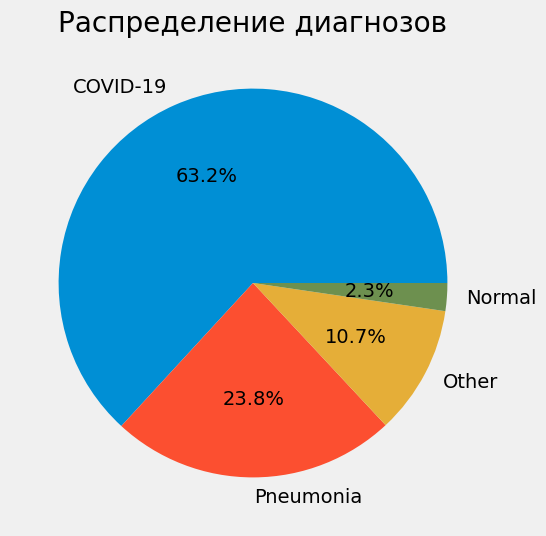

In [41]:
diag_pd = (
    df_proc.groupBy("diagnosis_std")
           .agg(F.count("*").alias("cnt"))
           .orderBy(F.desc("cnt"))
           .toPandas()
)
plt.figure(figsize=(6, 6))
plt.pie(diag_pd["cnt"], labels=diag_pd["diagnosis_std"], autopct="%1.1f%%")
plt.title("Распределение диагнозов")
plt.show()


Круговая диаграмма показывает преобладание COVID-19 (63%), за которым следует пневмония (25%), с небольшими долями "Normal" и "Other", подчёркивая фокус датасета на респираторных заболеваниях.


### Столбчатый график по возрастным категориям


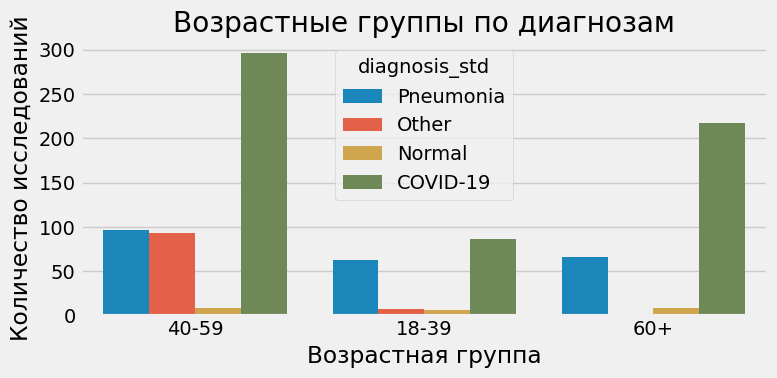

In [42]:
age_pd = (
    df_proc.groupBy("age_group", "diagnosis_std")
           .agg(F.count("*").alias("cnt"))
           .toPandas()
)
plt.figure(figsize=(8, 4))
sns.barplot(data=age_pd, x="age_group", y="cnt", hue="diagnosis_std")
plt.xlabel("Возрастная группа")
plt.ylabel("Количество исследований")
plt.title("Возрастные группы по диагнозам")
plt.tight_layout()
plt.show()


Столбчатая диаграмма иллюстрирует распределение рентгеновских снимков грудной клетки по возрастным категориям, сгруппированным по типам диагнозов. Максимальное число случаев COVID-19 наблюдается в возрастных группах 40–59 лет и старше 60 лет, что соответствует повышенной уязвимости взрослых и пожилых пациентов к тяжелым проявлениям инфекции. Аналогично, пневмония доминирует среди старших возрастных категорий и редко фиксируется у лиц младше 40 лет. Категории «Normal» и «Other» представлены в минимальном объеме, подтверждая фокус датасета на патологиях. Этот график способствует визуальному анализу возрастных рисков и может служить основой для сравнительных исследований болезней или разработки прогностических моделей.

### Линейный график тенденций по времени


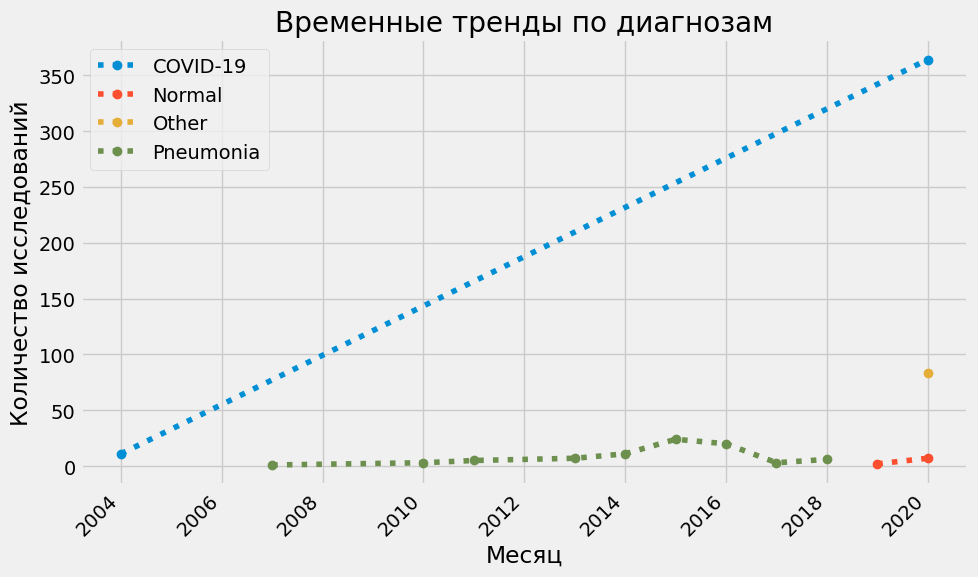

In [51]:
import matplotlib.pyplot as plt

trend_pd = sql_4.toPandas()
trend_pd = trend_pd.sort_values("month")

plt.figure(figsize=(10, 6))


# Группируем по диагнозу и строим графики с разными стилями
for i, (diag, part) in enumerate(trend_pd.groupby("condition")):
    plt.plot(part["month"], part["sample_count"], marker="o", linestyle=style, label=diag)

plt.xlabel("Месяц")
plt.ylabel("Количество исследований")
plt.title("Временные тренды по диагнозам")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Линейный график иллюстрирует временные тренды числа рентгеновских снимков по типам диагнозов. Заметен стремительный подъём случаев COVID-19 в 2020 году, отражающий начало пандемии и рост клинических публикаций. Ранее доминировали редкие инциденты пневмонии, SARS и прочих патологий, но в скромном объёме. На этом фоне другие диагнозы кажутся малозначимыми, подчёркивая акцент датасета на коронавирусных лёгочных поражениях. Тренд подкрепляет связь данных с глобальной эпидемией, где 2020 год стал pivotal периодом для выборки.

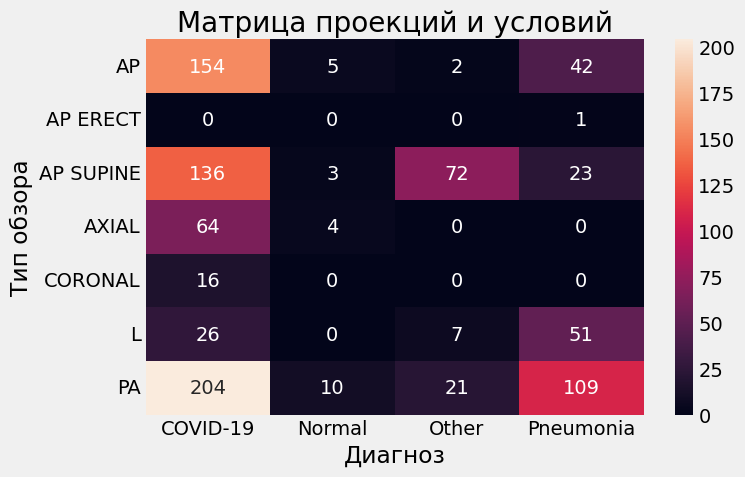

In [53]:
# Тепловая карта проекций и диагнозов
heat_chart = sql_5.toPandas()
matrix = heat_chart.pivot(index="view", columns="condition", values="sample_count").fillna(0)

plt.figure(figsize=(8, 5))
sns.heatmap(matrix, annot=True, fmt=".0f")
plt.title("Матрица проекций и условий")
plt.xlabel("Диагноз")
plt.ylabel("Тип обзора")
plt.tight_layout()
plt.show()


Тепловая карта демонстрирует корреляцию между видом рентгеновской проекции и диагностированными состояниями. Большинство случаев COVID-19 зафиксировано в позициях PA и AP SUPINE, указывая на применение этих укладок при критических ситуациях, когда пациентам противопоказано стояние. Пневмония преимущественно выявляется на PA-снимках, соответствующим стандартным протоколам грудной рентгенографии. Редкие проекции вроде AXIAL или CORONAL содержат минимальные данные, обусловленные спецификой аппаратуры и ограниченным использованием. Карта способствует определению оптимальных проекций для оценки респираторных патологий, потенциально интегрируемых в исследовательские и AI-диагностические инструменты.

# Заключение и выводы

Реализована аналитическая платформа для отслеживания эпидемии респираторных патологий через метаданные рентгеновских изображений. Начало включало конфигурацию окружения и инициализацию Spark-сессии для распределённой обработки. Затем проведена очистка метаданных: восполнили пробелы в возрасте, стандартизировали диагнозы, привели к единому формату гендерные обозначения и типы проекций. Даты оставили без искусственного заполнения, чтобы сохранить целостность временных паттернов для эпидемиологических исследований.

SQL-исследование выявило доминирование COVID-19 в датасете, обусловленное периодом сбора и фокусом создателей на коронавирусных лёгочных изменениях. Нормальные снимки минимальны, пневмония представлена в сравнимом объёме. Отмечены вариации по гендеру и возрасту, с преобладанием пациентов старше 40. Анализ хронологии подтвердил всплеск рентген-данных в 2020, совпадающий с пандемией.

Графическое представление раскрыло взаимосвязи между проекциями и диагнозами. Проекция PA лидирует, но значительная часть COVID-снимков — в AP SUPINE, намекая на серьёзность состояний. Очищенные данные экспортировали в Parquet для последующего анализа или компьютерного зрения.

В итоге, работа иллюстрирует применение Big Data и PySpark в медицинской аналитике. Результаты пригодны для создания предиктивных инструментов и диагностики, а также для изучения динамики лёгочных заболеваний. В перспективе анализ можно углубить, интегрируя метаданные с визуалами и применяя машинное обучение для автоматизированной категоризации рентгенов.